# Target

1. Use Dropout of 5%, 10%, 15% and 20% and select best of these 3 variants and report model's performance.


# Results

Total Parameters: 9894

Best Training Accuracy: 99.24

Best Test Accuracy: 99.36 

# Analysis

1. The model is not overfitting anymore. In fact, test accuracy is marginally better than training accuracy.  

2. However, both training as well as test accuracy can be improved. But we need to do this without increasing number of parameters too much.  

3. This is where GAP (Global Average Pooling) comes into play. This will be explored in the next Notebook. 

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 12, kernel_size=3, padding=0), # RF 3
            BatchNorm2d(12),           
            ReLU(inplace=True),
            nn.Dropout(0.05),            

            Conv2d(12, 12, kernel_size=3, padding=0), # RF 5
            BatchNorm2d(12),             
            ReLU(inplace=True),
            nn.Dropout(0.05),            

            Conv2d(12, 16, kernel_size=3, padding=0), # RF 7
            BatchNorm2d(16),             
            ReLU(inplace=True),
            nn.Dropout(0.05),                  

            MaxPool2d(kernel_size=2), # RF 8
            
            Conv2d(16, 12, kernel_size=1, padding=0), # RF 12
            BatchNorm2d(12),             
            ReLU(inplace=True),
            nn.Dropout(0.05),            

            Conv2d(12, 12, kernel_size=3, padding=0), # RF 12
            BatchNorm2d(12),             
            ReLU(inplace=True),
            nn.Dropout(0.05),            
            
            Conv2d(12, 12, kernel_size=3, padding=0), # RF 16
            BatchNorm2d(12),             
            ReLU(inplace=True),
            nn.Dropout(0.05),            

            Conv2d(12, 10, kernel_size=3, padding=0), # RF 20
            BatchNorm2d(10),             
            ReLU(inplace=True),

            Conv2d(10, 10, kernel_size=5, padding=0), # RF 24
            BatchNorm2d(10),             
            ReLU(inplace=True),

            Conv2d(10, 10, kernel_size=1) # RF 24

        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
       BatchNorm2d-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,308
       BatchNorm2d-6           [-1, 12, 24, 24]              24
              ReLU-7           [-1, 12, 24, 24]               0
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,744
      BatchNorm2d-10           [-1, 16, 22, 22]              32
             ReLU-11           [-1, 16, 22, 22]               0
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14           [-1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 16
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.10899225622415543 Batch_id=468 Accuracy=88.91: 100%|██████████| 469/469 [00:18<00:00, 25.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0867, Accuracy: 9777/10000 (97.77%)

EPOCH: 1


Loss=0.07257373631000519 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:17<00:00, 26.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0527, Accuracy: 9851/10000 (98.51%)

EPOCH: 2


Loss=0.04989538714289665 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:17<00:00, 26.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0514, Accuracy: 9850/10000 (98.50%)

EPOCH: 3


Loss=0.020087286829948425 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:17<00:00, 26.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Accuracy: 9888/10000 (98.88%)

EPOCH: 4


Loss=0.04713338240981102 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:17<00:00, 26.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9911/10000 (99.11%)

EPOCH: 5


Loss=0.006983076687902212 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:17<00:00, 26.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9925/10000 (99.25%)

EPOCH: 6


Loss=0.009442508220672607 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:17<00:00, 26.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9922/10000 (99.22%)

EPOCH: 7


Loss=0.01156878937035799 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:17<00:00, 26.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9917/10000 (99.17%)

EPOCH: 8


Loss=0.007376745343208313 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:17<00:00, 26.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9923/10000 (99.23%)

EPOCH: 9


Loss=0.029498940333724022 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:17<00:00, 26.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9916/10000 (99.16%)

EPOCH: 10


Loss=0.01014901977032423 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:17<00:00, 26.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9927/10000 (99.27%)

EPOCH: 11


Loss=0.023753082379698753 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:17<00:00, 26.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9921/10000 (99.21%)

EPOCH: 12


Loss=0.015472273342311382 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:17<00:00, 26.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9934/10000 (99.34%)

EPOCH: 13


Loss=0.009039893746376038 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:18<00:00, 26.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9936/10000 (99.36%)

EPOCH: 14


Loss=0.00550261652097106 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:17<00:00, 26.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9923/10000 (99.23%)

EPOCH: 15


Loss=0.0017363479128107429 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:17<00:00, 26.88it/s]



Test set: Average loss: 0.0224, Accuracy: 9935/10000 (99.35%)



Text(0.5, 1.0, 'Test Accuracy')

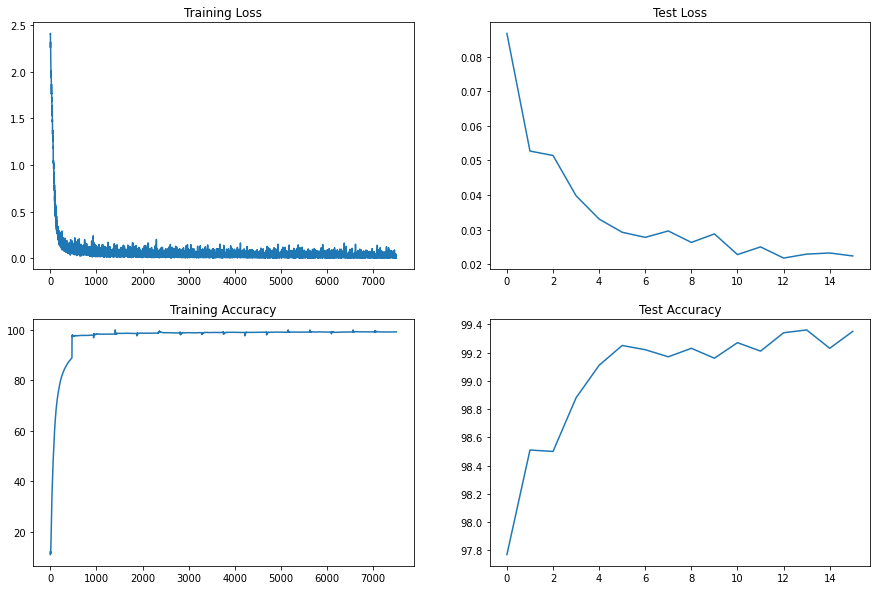

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")